In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv 
from codecarbon import OfflineEmissionsTracker

In [2]:
import os
cpu_count = os.cpu_count()
print(f"Number of CPU cores available: {cpu_count}")

Number of CPU cores available: 16


In [3]:
def get_dataloaders(batch_size = 256):
    """Prepares CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = False, transform = transform_train)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, pin_memory=True)
    
    testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = False, transform = transform_test)
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, pin_memory=True)
    
    return train_loader, test_loader
    

In [12]:
from torch.ao.quantization import QConfig, MovingAverageMinMaxObserver, default_weight_observer

def get_qat_model():
    """Returns a QAT-ready ResNet-18 model with a robust observer."""
    model = resnet18(weights=None, num_classes=10)
    model.quant = torch.ao.quantization.QuantStub()
    model.dequant = torch.ao.quantization.DeQuantStub()
    model.forward = lambda x: model.dequant(model._forward_impl(model.quant(x)))
    
    # --- Create a more stable QAT configuration ---
    # This uses an observer that is less sensitive to outlier batches.
    my_qat_qconfig = QConfig(
        activation=MovingAverageMinMaxObserver.with_args(quant_min=0, quant_max=255), 
        weight=default_weight_observer.with_args(quant_min=-128, quant_max=127)
    )

    model.train()
    
    # --- Apply the new, robust qconfig ---
    model.qconfig = my_qat_qconfig
    
    torch.ao.quantization.prepare_qat(model, inplace=True)
    return model

In [5]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler = None):
    """Runs one training epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.amp.autocast(device_type=device):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc
        

In [6]:
def validate(model, dataloader, criterion, device):
    """Runs Validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [7]:
# --- Global Settings ---
PATIENCE_VALUES = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
OUTPUT_DIR = "results"
MAX_EPOCHS = 200
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create output directory and load data once
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainloader, testloader = get_dataloaders()

print("Helper functions and global settings are defined.")

Helper functions and global settings are defined.


In [8]:

"""
# In[4]:
# ## 4. FP32 Training Runs
# This cell runs the grid search exclusively for FP32 precision.

print(f"\n{'='*60}")
print("STARTING ALL FP32 TRAINING RUNS")
print(f"{'='*60}\n")

for patience in PATIENCE_VALUES:
    print(f"\n--- New Run: FP32 with Patience = {patience} ---")
    model = resnet18(weights=None, num_classes=10).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
    
    log_file = os.path.join(OUTPUT_DIR, f'results_fp32_p{patience}.csv')
    best_acc, epochs_no_improve = 0.0, 0
    tracker = OfflineEmissionsTracker(country_iso_code="IND", output_dir=OUTPUT_DIR, log_level="error")
    
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'energy_kWh', 'co2_g'])
        tracker.start()
        
        last_energy_kwh = 0

        for epoch in range(MAX_EPOCHS):
            # --- Capture both train_loss and train_acc ---
            train_loss, train_acc = train_one_epoch(model, tqdm(trainloader, desc="Training", leave=False), criterion, optimizer, DEVICE)
            val_loss, val_acc = validate(model, tqdm(testloader, desc="Validating", leave=False), criterion, DEVICE)
            scheduler.step()
            
            # --- Log the new train_acc value ---
            emissions_kg = tracker.flush()
            emissions_g = emissions_kg * 1000
            
            current_energy_kwh = tracker._total_energy.kWh
            interval_energy_kwh = current_energy_kwh - last_energy_kwh
            last_energy_kwh = current_energy_kwh
            
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, interval_energy_kwh, emissions_g])
            f.flush()

            # Update best accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            # --- Modified Print and Early Stopping Logic ---
            if epochs_no_improve >= patience:
                print(f"--> Early stopping. Final Epoch: {epoch+1}, Val Acc: {val_acc:.2f}%, Best Acc: {best_acc:.2f}%")
                break
            if (epoch + 1) % 25 == 0:
                print(f"--> Checkpoint @ Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Best Acc: {best_acc:.2f}%")
        tracker.stop()
print("\nALL FP32 RUNS COMPLETED.")
"""

'\n# In[4]:\n# ## 4. FP32 Training Runs\n# This cell runs the grid search exclusively for FP32 precision.\n\nprint(f"\n{\'=\'*60}")\nprint("STARTING ALL FP32 TRAINING RUNS")\nprint(f"{\'=\'*60}\n")\n\nfor patience in PATIENCE_VALUES:\n    print(f"\n--- New Run: FP32 with Patience = {patience} ---")\n    model = resnet18(weights=None, num_classes=10).to(DEVICE)\n    criterion = nn.CrossEntropyLoss()\n    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)\n    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)\n\n    log_file = os.path.join(OUTPUT_DIR, f\'results_fp32_p{patience}.csv\')\n    best_acc, epochs_no_improve = 0.0, 0\n    tracker = OfflineEmissionsTracker(country_iso_code="IND", output_dir=OUTPUT_DIR, log_level="error")\n\n    with open(log_file, \'w\', newline=\'\') as f:\n        writer = csv.writer(f)\n        writer.writerow([\'epoch\', \'train_loss\', \'train_acc\', \'val_loss\', \'val_acc\', \'energy_

In [9]:
"""

# In[5]:2045
# ## 5. FP16 Training Runs
# This cell runs the grid search exclusively for FP16 (Mixed Precision).

print(f"\n{'='*60}")
print("STARTING ALL FP16 TRAINING RUNS")
print(f"{'='*60}\n")

for patience in PATIENCE_VALUES:
    print(f"\n--- New Run: FP16 with Patience = {patience} ---")
    model = resnet18(weights=None, num_classes=10).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
    scaler = torch.amp.GradScaler() # Enable scaler for FP16
    
    log_file = os.path.join(OUTPUT_DIR, f'results_fp16_p{patience}.csv')
    best_acc, epochs_no_improve = 0.0, 0
    tracker = OfflineEmissionsTracker(country_iso_code="IND", output_dir=OUTPUT_DIR, log_level="error")
    
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'energy_kWh', 'co2_g'])
        tracker.start()
        
        last_energy_kwh = 0
        
        for epoch in range(MAX_EPOCHS):
            train_loss, train_acc = train_one_epoch(model, tqdm(trainloader, desc="Training", leave=False), criterion, optimizer, DEVICE, scaler=scaler)
            val_loss, val_acc = validate(model, tqdm(testloader, desc="Validating", leave=False), criterion, DEVICE)
            scheduler.step()
            
            emissions_kg = tracker.flush()
            emissions_g = emissions_kg * 1000
            
            current_energy_kwh = tracker._total_energy.kWh
            interval_energy_kwh = current_energy_kwh - last_energy_kwh  
            last_energy_kwh = current_energy_kwh

            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, interval_energy_kwh, emissions_g])
            f.flush()

            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"--> Early stopping. Final Epoch: {epoch+1}, Val Acc: {val_acc:.2f}%, Best Acc: {best_acc:.2f}%")
                break
            if (epoch + 1) % 25 == 0:
                print(f"--> Checkpoint @ Epoch {epoch+1}: Val Acc: {val_acc:.2f}%, Best Acc: {best_acc:.2f}%")
        tracker.stop()
print("\nALL FP16 RUNS COMPLETED.")

"""

'\n\n# In[5]:2045\n# ## 5. FP16 Training Runs\n# This cell runs the grid search exclusively for FP16 (Mixed Precision).\n\nprint(f"\n{\'=\'*60}")\nprint("STARTING ALL FP16 TRAINING RUNS")\nprint(f"{\'=\'*60}\n")\n\nfor patience in PATIENCE_VALUES:\n    print(f"\n--- New Run: FP16 with Patience = {patience} ---")\n    model = resnet18(weights=None, num_classes=10).to(DEVICE)\n    criterion = nn.CrossEntropyLoss()\n    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)\n    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)\n    scaler = torch.amp.GradScaler() # Enable scaler for FP16\n\n    log_file = os.path.join(OUTPUT_DIR, f\'results_fp16_p{patience}.csv\')\n    best_acc, epochs_no_improve = 0.0, 0\n    tracker = OfflineEmissionsTracker(country_iso_code="IND", output_dir=OUTPUT_DIR, log_level="error")\n\n    with open(log_file, \'w\', newline=\'\') as f:\n        writer = csv.writer(f)\n        writer.writerow([\'

In [ ]:
"""

# In[6]:
# ## 6. INT8 QAT Training Runs
# This cell runs the grid search exclusively for INT8 Quantization-Aware Training.

print(f"\n{'='*60}")
print("STARTING ALL INT8 QAT TRAINING RUNS")
print(f"{'='*60}\n")

for patience in PATIENCE_VALUES:
    print(f"\n--- New Run: QAT with Patience = {patience} ---")
    model = get_qat_model().to(DEVICE) # Get the QAT-ready model
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
    
    log_file = os.path.join(OUTPUT_DIR, f'results_qat_p{patience}.csv')
    best_acc, epochs_no_improve = 0.0, 0
    tracker = OfflineEmissionsTracker(country_iso_code="IND", output_dir=OUTPUT_DIR, log_level="error")
    
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'energy_kWh', 'co2_g'])
        tracker.start()
        
        last_energy_kwh = 0
        
        for epoch in range(MAX_EPOCHS):
            train_loss, train_acc = train_one_epoch(model, tqdm(trainloader, desc="Training", leave=False), criterion, optimizer, DEVICE)
            val_loss, val_acc = validate(model, tqdm(testloader, desc="Validating", leave=False), criterion, DEVICE)
            scheduler.step()
            
            emissions_kg = tracker.flush()
            emissions_g = emissions_kg * 1000
            
            current_energy_kwh = tracker._total_energy.kWh
            interval_energy_kwh = current_energy_kwh - last_energy_kwh  
            last_energy_kwh = current_energy_kwh
            
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, interval_energy_kwh, emissions_g])
            f.flush()

            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"--> Early stopping. Final Epoch: {epoch+1}, Val Acc: {val_acc:.2f}%, Best Acc: {best_acc:.2f}%")
                break
            if (epoch + 1) % 25 == 0:
                print(f"--> Checkpoint @ Epoch {epoch+1}: Val Acc: {val_acc:.2f}%, Best Acc: {best_acc:.2f}%")
        tracker.stop()
print("\nALL QAT RUNS COMPLETED.")

"""


STARTING ALL INT8 QAT TRAINING RUNS


--- New Run: QAT with Patience = 5 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 76.48%, Best Acc: 76.58%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Early stopping. Final Epoch: 39, Val Acc: 77.79%, Best Acc: 79.26%

--- New Run: QAT with Patience = 10 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 73.27%, Best Acc: 76.34%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Early stopping. Final Epoch: 43, Val Acc: 78.29%, Best Acc: 79.26%

--- New Run: QAT with Patience = 15 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 77.37%, Best Acc: 77.37%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 80.79%, Best Acc: 80.79%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Early stopping. Final Epoch: 74, Val Acc: 79.34%, Best Acc: 81.40%

--- New Run: QAT with Patience = 20 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 74.46%, Best Acc: 77.58%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 78.93%, Best Acc: 80.45%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Early stopping. Final Epoch: 63, Val Acc: 79.52%, Best Acc: 80.45%

--- New Run: QAT with Patience = 25 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 78.64%, Best Acc: 78.64%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 79.44%, Best Acc: 79.77%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 75: Val Acc: 81.21%, Best Acc: 81.21%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 100: Val Acc: 81.76%, Best Acc: 82.79%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 125: Val Acc: 83.51%, Best Acc: 84.51%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 150: Val Acc: 86.35%, Best Acc: 86.35%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 175: Val Acc: 87.74%, Best Acc: 88.04%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 200: Val Acc: 88.34%, Best Acc: 88.54%

--- New Run: QAT with Patience = 30 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 75.81%, Best Acc: 76.37%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 79.04%, Best Acc: 80.04%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 75: Val Acc: 80.67%, Best Acc: 82.06%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 100: Val Acc: 82.65%, Best Acc: 82.85%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 125: Val Acc: 84.31%, Best Acc: 84.71%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 150: Val Acc: 85.49%, Best Acc: 86.26%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 175: Val Acc: 87.74%, Best Acc: 87.98%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 200: Val Acc: 88.16%, Best Acc: 88.26%

--- New Run: QAT with Patience = 35 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 75.76%, Best Acc: 78.72%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 78.67%, Best Acc: 80.31%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 75: Val Acc: 80.87%, Best Acc: 82.41%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 100: Val Acc: 80.11%, Best Acc: 83.36%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 125: Val Acc: 84.01%, Best Acc: 85.09%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 150: Val Acc: 86.14%, Best Acc: 86.72%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 175: Val Acc: 88.06%, Best Acc: 88.30%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 200: Val Acc: 88.90%, Best Acc: 88.97%

--- New Run: QAT with Patience = 40 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 76.17%, Best Acc: 76.43%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 78.29%, Best Acc: 80.17%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 75: Val Acc: 81.48%, Best Acc: 81.73%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 100: Val Acc: 82.15%, Best Acc: 83.28%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 125: Val Acc: 85.37%, Best Acc: 85.37%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 150: Val Acc: 85.67%, Best Acc: 86.29%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 175: Val Acc: 87.78%, Best Acc: 88.32%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 200: Val Acc: 88.60%, Best Acc: 88.71%

--- New Run: QAT with Patience = 45 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 75.56%, Best Acc: 77.27%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 79.38%, Best Acc: 79.87%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 75: Val Acc: 78.64%, Best Acc: 82.52%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 100: Val Acc: 82.01%, Best Acc: 82.59%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 125: Val Acc: 84.28%, Best Acc: 84.49%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 150: Val Acc: 86.06%, Best Acc: 86.39%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 175: Val Acc: 88.05%, Best Acc: 88.08%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 200: Val Acc: 88.53%, Best Acc: 88.74%

--- New Run: QAT with Patience = 50 ---


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 25: Val Acc: 74.51%, Best Acc: 77.06%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 50: Val Acc: 80.16%, Best Acc: 80.86%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 75: Val Acc: 81.50%, Best Acc: 81.88%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 100: Val Acc: 82.02%, Best Acc: 83.59%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 125: Val Acc: 83.68%, Best Acc: 85.24%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 150: Val Acc: 85.49%, Best Acc: 86.13%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 175: Val Acc: 88.19%, Best Acc: 88.19%


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

--> Checkpoint @ Epoch 200: Val Acc: 88.55%, Best Acc: 88.56%

ALL QAT RUNS COMPLETED.



--- Optimal Run Summary ---
precision  Optimal Patience  Best Validation Accuracy  Total Energy (kWh)
      QAT                35                     88.97            0.156059
     FP32                45                     88.70            0.381250
     FP16                35                     88.74            0.455394
---------------------------



C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_45804\3120383584.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='precision', y='Optimal Patience', data=optimal_df, ax=axes[0], palette='viridis', order=['FP32', 'FP16', 'QAT'])
C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_45804\3120383584.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='precision', y='Best Validation Accuracy', data=optimal_df, ax=axes[1], palette='plasma', order=['FP32', 'FP16', 'QAT'])
C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_45804\3120383584.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue

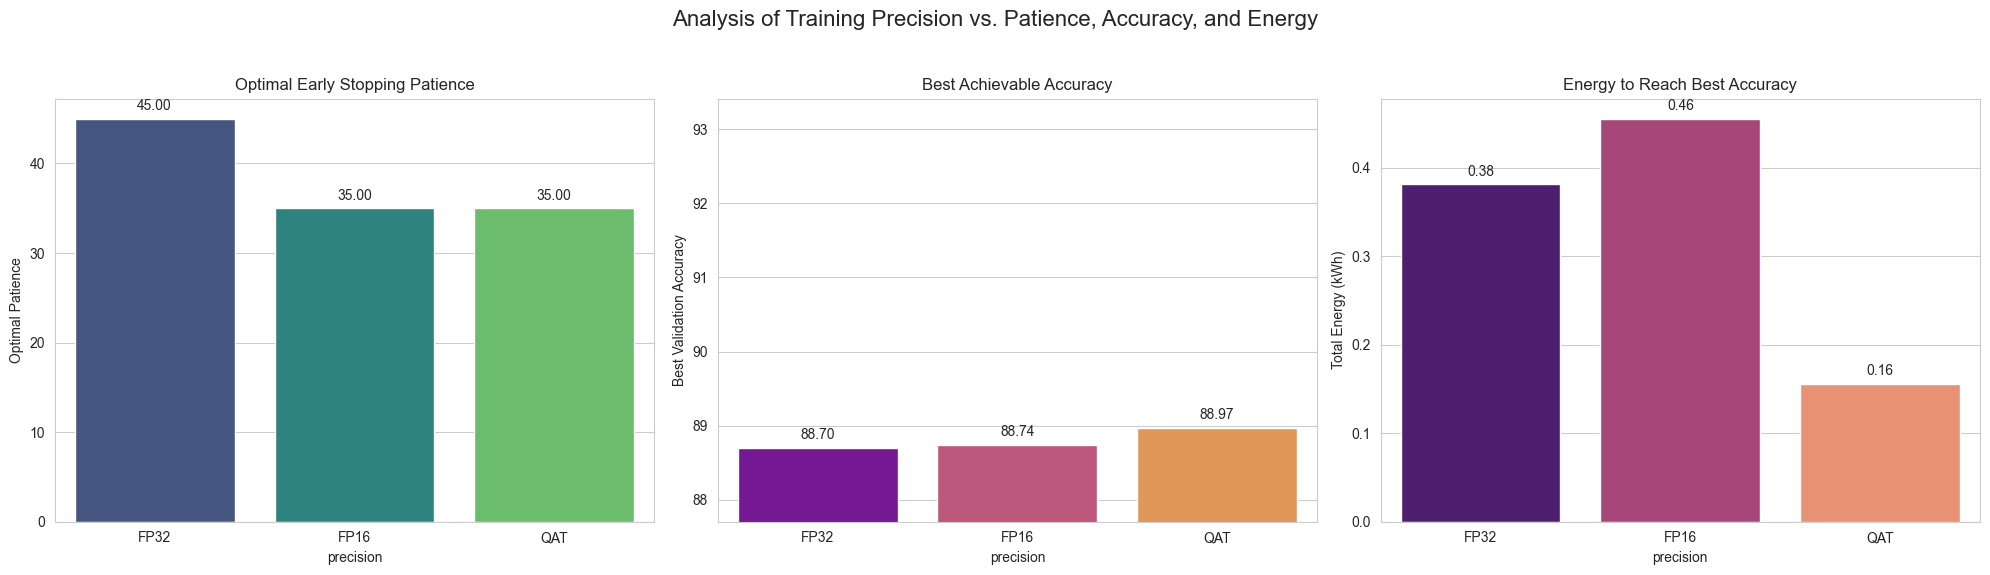

In [14]:
# In[7]:
# ## 7. Analyze and Plot Results 📊
# This final cell loads data from all CSVs, finds the optimal run for each
# precision, and generates the summary plots.

import glob

def load_data(results_dir='results'):
    """Load all experiment logs into a single DataFrame."""
    all_files = glob.glob(os.path.join(results_dir, "results_*.csv"))
    df_list = []
    for filename in all_files:
        try:
            parts = os.path.basename(filename).replace('.csv', '').split('_')
            precision = parts[1]
            patience = int(parts[2][1:])
            df = pd.read_csv(filename)
            df['precision'] = precision.upper()
            df['patience'] = patience
            df['cumulative_energy_kWh'] = df['energy_kWh'].cumsum()
            df['cumulative_co2_g'] = df['co2_g'].cumsum()
            df_list.append(df)
        except Exception as e:
            print(f"Could not process file {filename}: {e}")
    if not df_list:
        return pd.DataFrame()
    return pd.concat(df_list, ignore_index=True)

def find_optimal_runs(df):
    """Find the best run for each precision type."""
    idx = df.groupby(['precision', 'patience'])['val_acc'].idxmax()
    best_runs_df = df.loc[idx]
    optimal_idx = best_runs_df.groupby('precision')['val_acc'].idxmax()
    optimal_df = best_runs_df.loc[optimal_idx].sort_values(by='precision', ascending=False)
    return optimal_df.rename(columns={
        'val_acc': 'Best Validation Accuracy',
        'patience': 'Optimal Patience',
        'cumulative_energy_kWh': 'Total Energy (kWh)'
    })

def plot_results(optimal_df):
    """Generate and save the summary plots."""
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Analysis of Training Precision vs. Patience, Accuracy, and Energy', fontsize=16)

    sns.barplot(x='precision', y='Optimal Patience', data=optimal_df, ax=axes[0], palette='viridis', order=['FP32', 'FP16', 'QAT'])
    axes[0].set_title('Optimal Early Stopping Patience')

    sns.barplot(x='precision', y='Best Validation Accuracy', data=optimal_df, ax=axes[1], palette='plasma', order=['FP32', 'FP16', 'QAT'])
    axes[1].set_title('Best Achievable Accuracy')
    axes[1].set_ylim(bottom=max(0, optimal_df['Best Validation Accuracy'].min() - 1))

    sns.barplot(x='precision', y='Total Energy (kWh)', data=optimal_df, ax=axes[2], palette='magma', order=['FP32', 'FP16', 'QAT'])
    axes[2].set_title('Energy to Reach Best Accuracy')
    
    for ax in axes:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('experiment_summary.png', dpi=300)
    plt.show()

# --- Run Analysis ---
all_data = load_data()
if not all_data.empty:
    optimal_runs = find_optimal_runs(all_data)
    print("\n--- Optimal Run Summary ---")
    print(optimal_runs[['precision', 'Optimal Patience', 'Best Validation Accuracy', 'Total Energy (kWh)']].to_string(index=False))
    print("---------------------------\n")
    plot_results(optimal_runs)
else:
    print("No data found in the 'results' folder. Make sure the experiment cells have run successfully.")

In [18]:
import seaborn as sns
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = 'results'
sns.set_theme(style="whitegrid", palette="viridis")

In [19]:
def load_data(results_dir):
    """Load all experiment logs into a single DataFrame."""
    all_files = glob.glob(os.path.join(results_dir, "results_*.csv"))
    if not all_files:
        print(f"Error: No CSV files found in the '{results_dir}' directory.")
        return pd.DataFrame()
        
    df_list = []
    for filename in all_files:
        try:
            parts = os.path.basename(filename).replace('.csv', '').split('_')
            precision = parts[1].upper()
            patience = int(parts[2][1:])
            df = pd.read_csv(filename)
            df['precision'] = precision
            df['patience'] = patience
            df['cumulative_energy_kWh'] = df['energy_kWh'].cumsum()
            df['cumulative_co2_g'] = df['co2_g'].cumsum()
            df['filename'] = os.path.basename(filename)
            df_list.append(df)
        except Exception as e:
            print(f"Could not process file {filename}: {e}")
    return pd.concat(df_list, ignore_index=True)

In [20]:
def get_optimal_run_files(df):
    """Identify the filename of the best run for each precision type."""
    # Find the best accuracy achieved for each run (precision-patience combination)
    idx = df.groupby(['precision', 'patience'])['val_acc'].idxmax()
    best_runs_df = df.loc[idx]

    # From those best runs, find the one with the highest accuracy for each precision type
    optimal_idx = best_runs_df.groupby('precision')['val_acc'].idxmax()
    optimal_files = best_runs_df.loc[optimal_idx]['filename'].tolist()
    
    return optimal_files

Identified optimal run files: ['results_fp16_p35.csv', 'results_fp32_p45.csv', 'results_qat_p35.csv']

Saved learning curve plot to plot_1_learning_curves.png


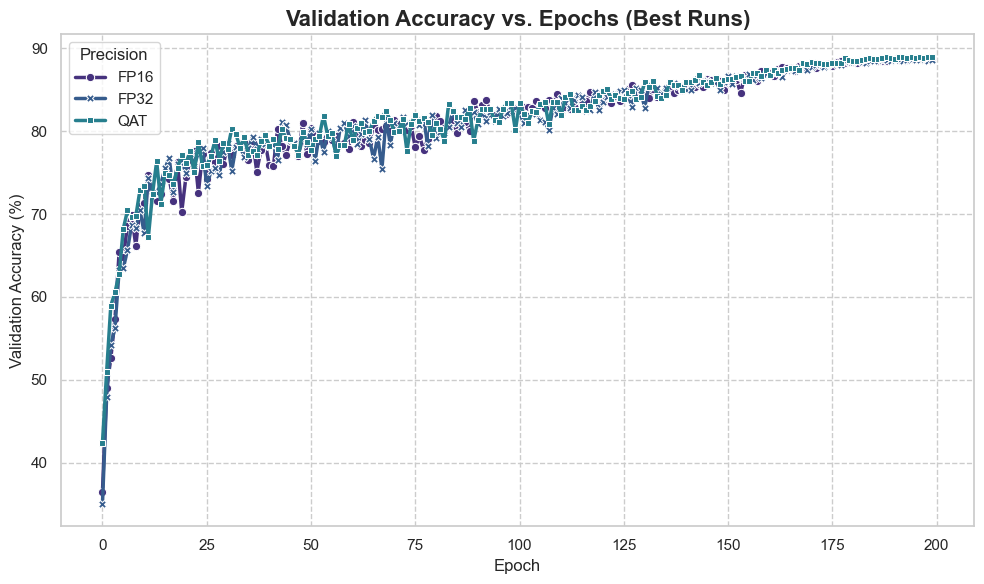

Saved energy over time plot to plot_2_energy_over_time.png


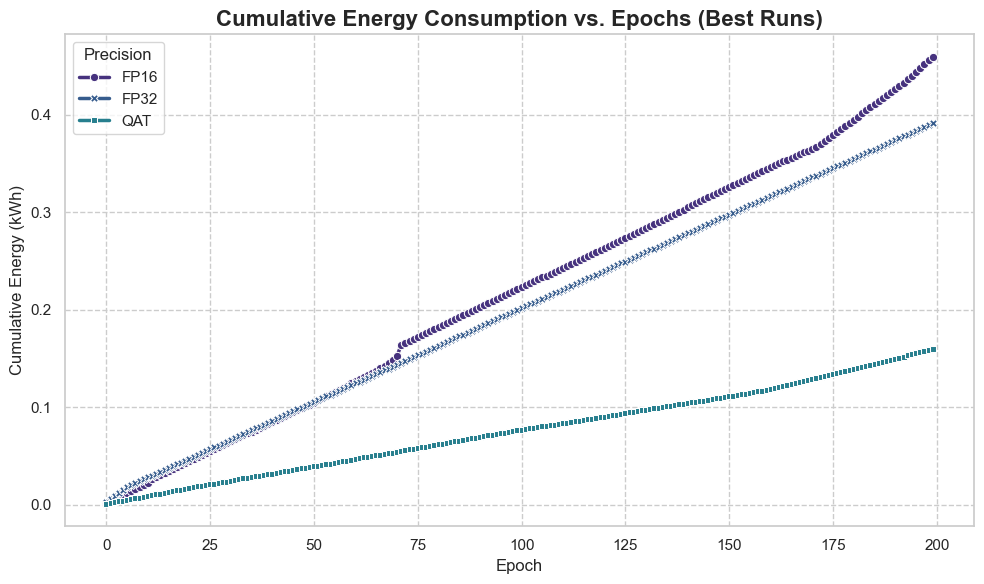

Saved cost of accuracy plot to plot_3_cost_of_accuracy.png


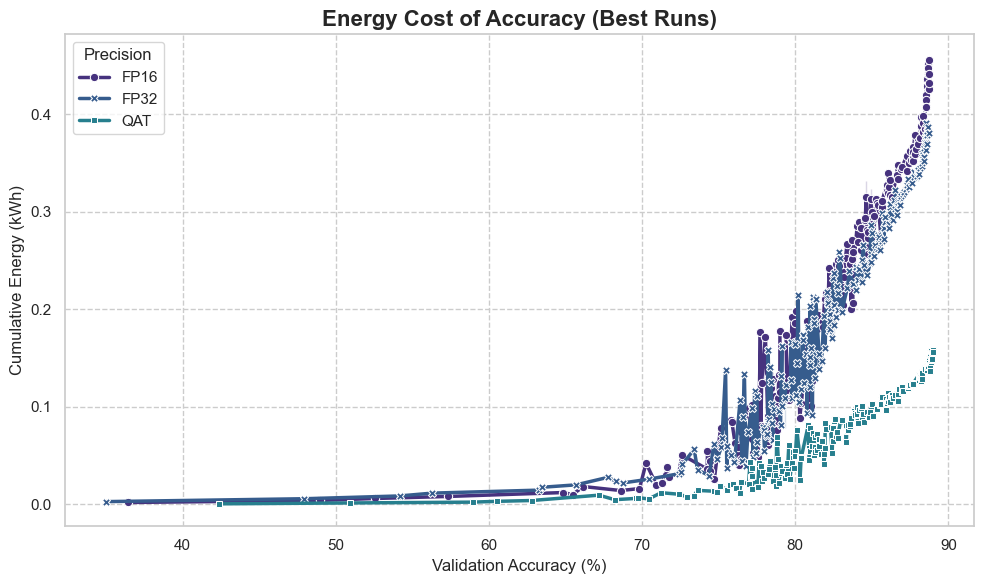

Saved hyperparameter sensitivity plot to plot_4_patience_sensitivity.png


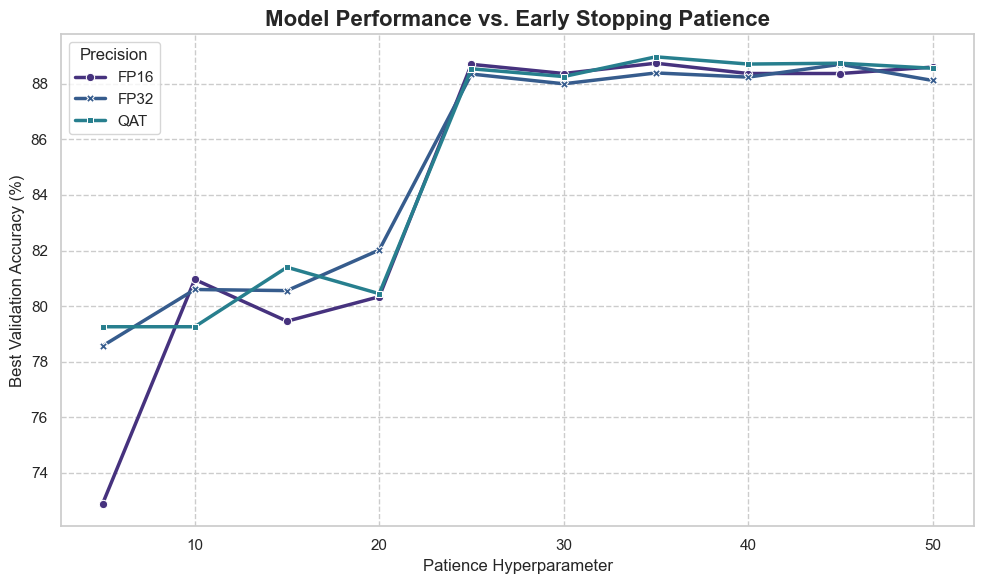

In [21]:
def plot_learning_curves(df, optimal_files, save_path="plot_1_learning_curves.png"):
    """Plots validation accuracy vs. epochs for the best models."""
    plt.figure(figsize=(10, 6))
    
    # Filter for only the optimal runs
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    ax = sns.lineplot(data=df_optimal, x='epoch', y='val_acc', hue='precision', lw=2.5, style='precision', markers=True, dashes=False)
    
    plt.title('Validation Accuracy vs. Epochs (Best Runs)', fontsize=16, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.legend(title='Precision')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved learning curve plot to {save_path}")
    plt.show()


def plot_energy_over_time(df, optimal_files, save_path="plot_2_energy_over_time.png"):
    """Plots cumulative energy vs. epochs for the best models."""
    plt.figure(figsize=(10, 6))
    
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    sns.lineplot(data=df_optimal, x='epoch', y='cumulative_energy_kWh', hue='precision', lw=2.5, style='precision', markers=True, dashes=False)
    
    plt.title('Cumulative Energy Consumption vs. Epochs (Best Runs)', fontsize=16, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Cumulative Energy (kWh)', fontsize=12)
    plt.legend(title='Precision')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved energy over time plot to {save_path}")
    plt.show()


def plot_cost_of_accuracy(df, optimal_files, save_path="plot_3_cost_of_accuracy.png"):
    """Plots cumulative energy vs. validation accuracy for the best models."""
    plt.figure(figsize=(10, 6))
    
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    sns.lineplot(data=df_optimal, x='val_acc', y='cumulative_energy_kWh', hue='precision', lw=2.5, style='precision', markers=True, dashes=False)
    
    plt.title('Energy Cost of Accuracy (Best Runs)', fontsize=16, weight='bold')
    plt.xlabel('Validation Accuracy (%)', fontsize=12)
    plt.ylabel('Cumulative Energy (kWh)', fontsize=12)
    plt.legend(title='Precision')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved cost of accuracy plot to {save_path}")
    plt.show()


def plot_hyperparameter_sensitivity(df, save_path="plot_4_patience_sensitivity.png"):
    """Plots final validation accuracy vs. patience for each precision."""
    plt.figure(figsize=(10, 6))
    
    # Find the maximum accuracy for each precision-patience combination
    sensitivity_df = df.groupby(['precision', 'patience'])['val_acc'].max().reset_index()
    
    sns.lineplot(data=sensitivity_df, x='patience', y='val_acc', hue='precision', lw=2.5, style='precision', markers=True, dashes=False)
    
    plt.title('Model Performance vs. Early Stopping Patience', fontsize=16, weight='bold')
    plt.xlabel('Patience Hyperparameter', fontsize=12)
    plt.ylabel('Best Validation Accuracy (%)', fontsize=12)
    plt.legend(title='Precision')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved hyperparameter sensitivity plot to {save_path}")
    plt.show()


# --- Main Execution Block ---
if __name__ == "__main__":
    # Load all the data from the results directory
    full_df = load_data(RESULTS_DIR)
    
    if not full_df.empty:
        # Find the best performing run for each precision
        optimal_files = get_optimal_run_files(full_df)
        print(f"Identified optimal run files: {optimal_files}\n")

        # Generate and display each plot
        plot_learning_curves(full_df, optimal_files)
        plot_energy_over_time(full_df, optimal_files)
        plot_cost_of_accuracy(full_df, optimal_files)
        plot_hyperparameter_sensitivity(full_df)
    else:
        print("Analysis aborted as no data was loaded.")

--- Optimal Run Summary ---
precision  Best Validation Accuracy  Total Energy (kWh)  Total CO2 (g)  Optimal Patience             filename
     FP16                     88.74            0.455394   30863.816251                35 results_fp16_p35.csv
     FP32                     88.70            0.381250   27148.440155                45 results_fp32_p45.csv
      QAT                     88.97            0.156059   10535.042971                35  results_qat_p35.csv
-------------------------
Saved overfitting gap plot to plot_5_overfitting_gap.png


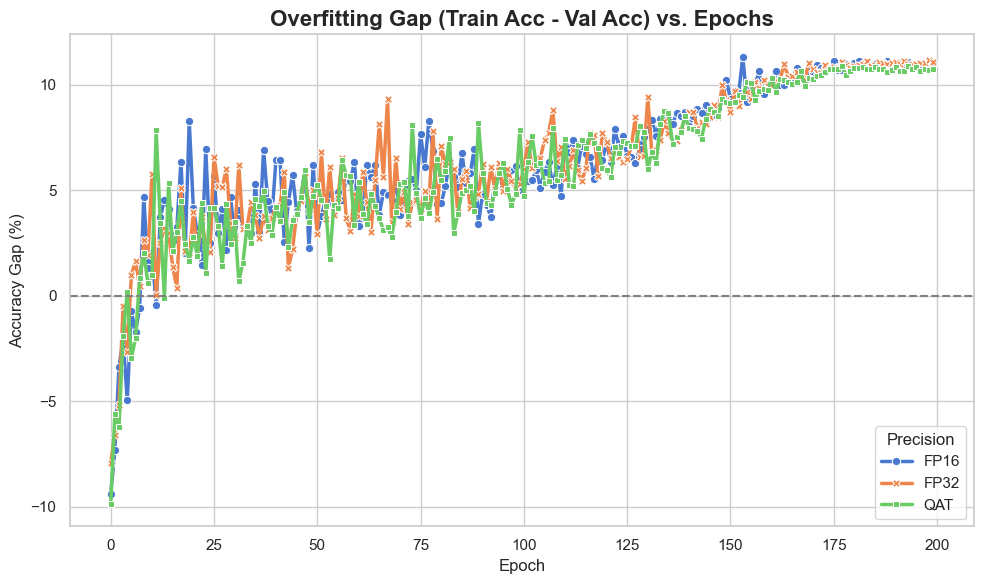


Analyzing epochs to reach 92.0% accuracy...
Aborting plot: No models reached the 92.0% accuracy target.
Saved bubble chart to plot_7_bubble_chart.png


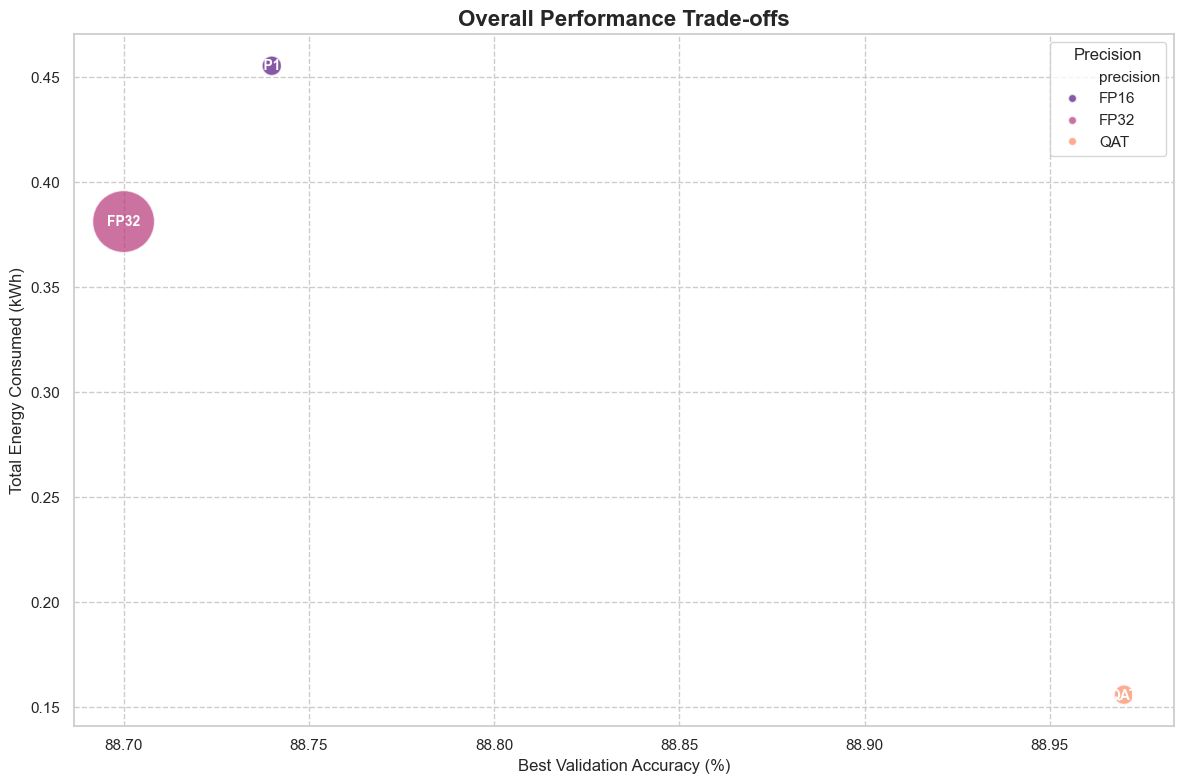

C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\3244512989.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary_df, x='precision', y='Total CO2 (g)', palette='cividis')
C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\3244512989.py:180: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\3244512989.py:183: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


Saved carbon footprint plot to plot_8_carbon_footprint.png


C:\Users\Priangshu Paul\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


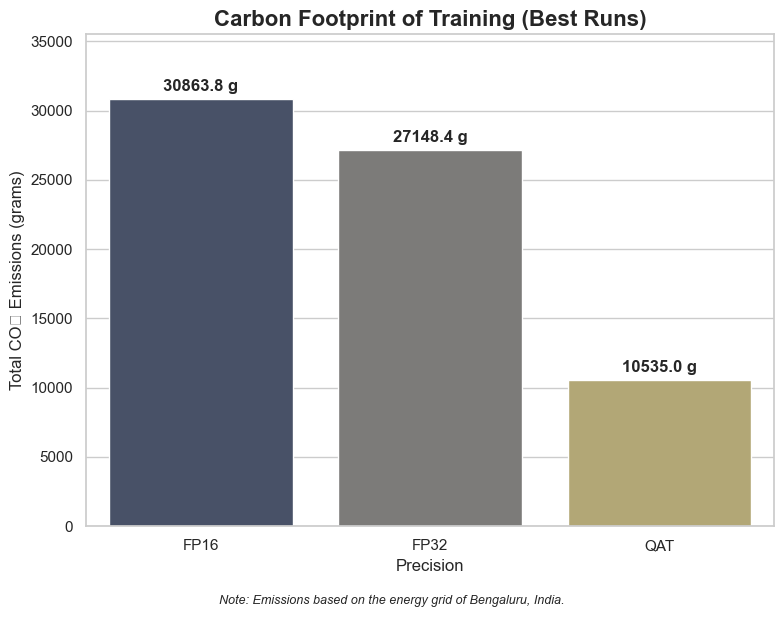

In [ ]:
import numpy as np

# --- Configuration ---
RESULTS_DIR = 'results'
sns.set_theme(style="whitegrid", palette="muted")

# --- Data Loading and Processing ---

def load_data(results_dir):
    """Load all experiment logs into a single DataFrame."""
    all_files = glob.glob(os.path.join(results_dir, "results_*.csv"))
    if not all_files:
        print(f"Error: No CSV files found in the '{results_dir}' directory.")
        return pd.DataFrame()
        
    df_list = []
    for filename in all_files:
        try:
            parts = os.path.basename(filename).replace('.csv', '').split('_')
            precision = parts[1].upper()
            patience = int(parts[2][1:])
            df = pd.read_csv(filename)
            # Recalculate cumulative stats per file
            df['cumulative_energy_kWh'] = df['energy_kWh'].cumsum()
            df['cumulative_co2_g'] = df['co2_g'].cumsum()
            df['precision'] = precision
            df['patience'] = patience
            df['filename'] = os.path.basename(filename)
            df_list.append(df)
        except Exception as e:
            print(f"Could not process file {filename}: {e}")
    return pd.concat(df_list, ignore_index=True)

def get_summary_df(df):
    """Processes the full dataframe to get a summary of the best run for each precision."""
    # Find the best accuracy achieved for each run (precision-patience combination)
    idx_max_acc_per_run = df.groupby(['precision', 'patience'])['val_acc'].idxmax()
    best_of_each_run_df = df.loc[idx_max_acc_per_run]

    # From those, find the single best run for each precision
    idx_optimal_runs = best_of_each_run_df.groupby('precision')['val_acc'].idxmax()
    summary_df = best_of_each_run_df.loc[idx_optimal_runs].reset_index(drop=True)
    
    # Rename columns for clarity in plots
    summary_df = summary_df.rename(columns={
        'val_acc': 'Best Validation Accuracy',
        'patience': 'Optimal Patience',
        'cumulative_energy_kWh': 'Total Energy (kWh)',
        'cumulative_co2_g': 'Total CO2 (g)'
    })
    return summary_df

# --- Plotting Functions ---

def plot_overfitting_gap(df, optimal_files, save_path="plot_5_overfitting_gap.png"):
    """Plots the gap between training and validation accuracy."""
    plt.figure(figsize=(10, 6))
    
    df_optimal = df[df['filename'].isin(optimal_files)].copy()
    df_optimal['acc_gap'] = df_optimal['train_acc'] - df_optimal['val_acc']
    
    sns.lineplot(data=df_optimal, x='epoch', y='acc_gap', hue='precision', lw=2.5, style='precision', markers=True, dashes=False)
    
    plt.axhline(0, color='grey', linestyle='--')
    plt.title('Overfitting Gap (Train Acc - Val Acc) vs. Epochs', fontsize=16, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy Gap (%)', fontsize=12)
    plt.legend(title='Precision')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved overfitting gap plot to {save_path}")
    plt.show()

def plot_epochs_to_target(df, optimal_files, target_acc=88.0, save_path="plot_6_epochs_to_target.png"):
    """
    Plots a bar chart of epochs needed to reach a target validation accuracy.
    This version gracefully handles cases where the target is not reached.
    """
    print(f"\nAnalyzing epochs to reach {target_acc}% accuracy...")
    
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    epochs_needed = {}
    for precision in sorted(df_optimal['precision'].unique()):
        precision_df = df_optimal[df_optimal['precision'] == precision]
        # Find the first epoch where val_acc meets or exceeds the target
        target_epoch_df = precision_df[precision_df['val_acc'] >= target_acc]
        
        if not target_epoch_df.empty:
            epochs_needed[precision] = target_epoch_df['epoch'].min() + 1 # Use epoch number (1-based)
        else:
            epochs_needed[precision] = np.nan # Assign NaN if target is never reached

    epochs_df = pd.DataFrame(list(epochs_needed.items()), columns=['precision', 'epochs_to_target'])

    # --- ROBUSTNESS FIX STARTS HERE ---

    # 1. Identify and report models that did not reach the target
    failed_models = epochs_df[epochs_df['epochs_to_target'].isna()]['precision'].tolist()
    if failed_models:
        print(f"Warning: The following models never reached {target_acc}% accuracy and will be excluded from this plot: {failed_models}")

    # 2. Create a new dataframe for plotting with NaN values removed
    plot_df = epochs_df.dropna()

    if plot_df.empty:
        print(f"Aborting plot: No models reached the {target_acc}% accuracy target.")
        return

    # --- PLOTTING LOGIC ---
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=plot_df, x='precision', y='epochs_to_target', palette='plasma', order=sorted(plot_df['precision'].unique()))
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

    plt.title(f'Epochs Needed to Reach {target_acc:.0f}% Validation Accuracy', fontsize=16, weight='bold')
    plt.xlabel('Precision', fontsize=12)
    plt.ylabel('Epochs', fontsize=12)
    plt.ylim(0, plot_df['epochs_to_target'].max() * 1.15) # Use plot_df to calculate max
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved epochs-to-target plot to {save_path}")
    plt.show()

def plot_multi_metric_bubble_chart(summary_df, save_path="plot_7_bubble_chart.png"):
    """Creates a bubble chart summarizing accuracy, energy, and patience."""
    plt.figure(figsize=(12, 8))
    
    ax = sns.scatterplot(
        data=summary_df,
        x='Best Validation Accuracy',
        y='Total Energy (kWh)',
        size='Optimal Patience',
        hue='precision',
        sizes=(200, 2000),  # Control min and max bubble size
        alpha=0.7,
        palette='magma'
    )
    
    # Add labels for each bubble
    for i in range(summary_df.shape[0]):
        plt.text(x=summary_df['Best Validation Accuracy'][i],
                 y=summary_df['Total Energy (kWh)'][i],
                 s=summary_df['precision'][i],
                 fontdict=dict(color='white', size=10, weight='bold'),
                 ha='center', va='center')

    plt.title('Overall Performance Trade-offs', fontsize=16, weight='bold')
    plt.xlabel('Best Validation Accuracy (%)', fontsize=12)
    plt.ylabel('Total Energy Consumed (kWh)', fontsize=12)
    # Customize legend
    h, l = ax.get_legend_handles_labels()
    # Separate hue and size legends
    plt.legend(h[0:4], l[0:4], title='Precision')
    
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved bubble chart to {save_path}")
    plt.show()

def plot_carbon_footprint(summary_df, save_path="plot_8_carbon_footprint.png"):
    """Creates a bar chart of the final CO2 emissions."""
    plt.figure(figsize=(8, 6))
    
    ax = sns.barplot(data=summary_df, x='precision', y='Total CO2 (g)', palette='cividis')

    plt.title('Carbon Footprint of Training (Best Runs)', fontsize=16, weight='bold')
    plt.xlabel('Precision', fontsize=12)
    plt.ylabel('Total CO₂ Emissions (grams)', fontsize=12)
    
    # Add text labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f} g', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

    plt.ylim(0, summary_df['Total CO2 (g)'].max() * 1.15)
    plt.tight_layout()
    # Add a note about the location
    plt.figtext(0.5, -0.02, "Note: Emissions based on the energy grid of Bengaluru, India.", ha="center", fontsize=9, style='italic')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved carbon footprint plot to {save_path}")
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    full_df = load_data(RESULTS_DIR)
    
    if not full_df.empty:
        # Create a summary of the best runs
        summary_df = get_summary_df(full_df)
        print("--- Optimal Run Summary ---")
        print(summary_df[['precision', 'Best Validation Accuracy', 'Total Energy (kWh)', 'Total CO2 (g)', 'Optimal Patience', 'filename']].to_string(index=False))
        print("-" * 25)

        # Get the filenames of the optimal runs for time-series plots
        optimal_files = summary_df['filename'].tolist()

        # Generate and display each plot
        plot_overfitting_gap(full_df, optimal_files)
        plot_epochs_to_target(full_df, optimal_files, target_acc=92.0)
        plot_multi_metric_bubble_chart(summary_df)
        plot_carbon_footprint(summary_df)
    else:
        print("Analysis aborted as no data was loaded.")

--- Optimal Run Summary ---
precision  Best Validation Accuracy  Total Energy (kWh)  Total CO2 (g)  Optimal Patience             filename
     FP16                     88.74            0.455394   30863.816251                35 results_fp16_p35.csv
     FP32                     88.70            0.381250   27148.440155                45 results_fp32_p45.csv
      QAT                     88.97            0.156059   10535.042971                35  results_qat_p35.csv
-------------------------

Analyzing epochs to reach 88.0% accuracy...


C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\1634793464.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='precision', y='epochs_to_target', palette='plasma', order=sorted(plot_df['precision'].unique()))


Saved epochs-to-target plot to plot_6_epochs_to_target.png


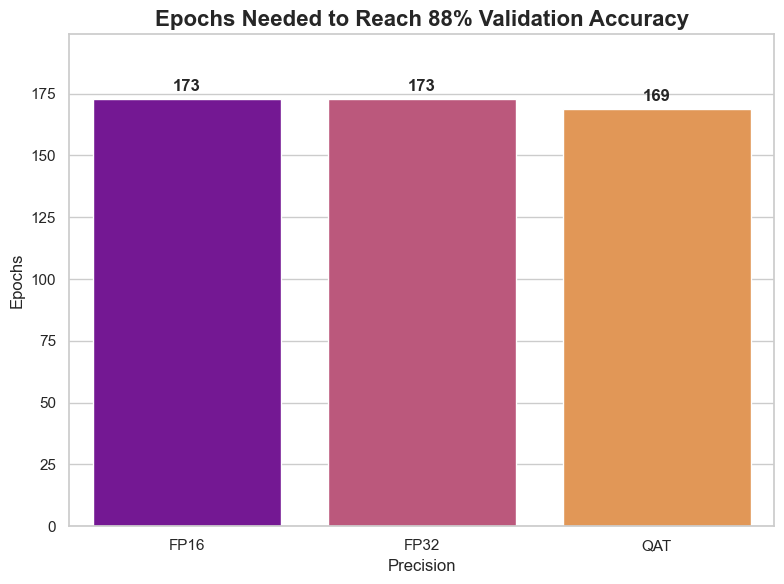

In [27]:
def plot_epochs_to_target(df, optimal_files, target_acc=88.0, save_path="plot_6_epochs_to_target.png"):
    """
    Plots a bar chart of epochs needed to reach a target validation accuracy.
    This version gracefully handles cases where the target is not reached.
    """
    print(f"\nAnalyzing epochs to reach {target_acc}% accuracy...")
    
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    epochs_needed = {}
    for precision in sorted(df_optimal['precision'].unique()):
        precision_df = df_optimal[df_optimal['precision'] == precision]
        # Find the first epoch where val_acc meets or exceeds the target
        target_epoch_df = precision_df[precision_df['val_acc'] >= target_acc]
        
        if not target_epoch_df.empty:
            epochs_needed[precision] = target_epoch_df['epoch'].min() + 1 # Use epoch number (1-based)
        else:
            epochs_needed[precision] = np.nan # Assign NaN if target is never reached

    epochs_df = pd.DataFrame(list(epochs_needed.items()), columns=['precision', 'epochs_to_target'])

    # --- ROBUSTNESS FIX STARTS HERE ---

    # 1. Identify and report models that did not reach the target
    failed_models = epochs_df[epochs_df['epochs_to_target'].isna()]['precision'].tolist()
    if failed_models:
        print(f"Warning: The following models never reached {target_acc}% accuracy and will be excluded from this plot: {failed_models}")

    # 2. Create a new dataframe for plotting with NaN values removed
    plot_df = epochs_df.dropna()

    if plot_df.empty:
        print(f"Aborting plot: No models reached the {target_acc}% accuracy target.")
        return

    # --- PLOTTING LOGIC ---
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=plot_df, x='precision', y='epochs_to_target', palette='plasma', order=sorted(plot_df['precision'].unique()))
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

    plt.title(f'Epochs Needed to Reach {target_acc:.0f}% Validation Accuracy', fontsize=16, weight='bold')
    plt.xlabel('Precision', fontsize=12)
    plt.ylabel('Epochs', fontsize=12)
    plt.ylim(0, plot_df['epochs_to_target'].max() * 1.15) # Use plot_df to calculate max
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved epochs-to-target plot to {save_path}")
    plt.show()
    
if __name__ == "__main__":
    full_df = load_data(RESULTS_DIR)
    
    if not full_df.empty:
        # Create a summary of the best runs
        summary_df = get_summary_df(full_df)
        print("--- Optimal Run Summary ---")
        print(summary_df[['precision', 'Best Validation Accuracy', 'Total Energy (kWh)', 'Total CO2 (g)', 'Optimal Patience', 'filename']].to_string(index=False))
        print("-" * 25)

        # Get the filenames of the optimal runs for time-series plots
        optimal_files = summary_df['filename'].tolist()

        # Generate and display each plot
        plot_epochs_to_target(full_df, optimal_files, target_acc=88.0)
    else:
        print("Analysis aborted as no data was loaded.")

Identified optimal run files for time-series plots: ['results_fp16_p35.csv', 'results_fp32_p45.csv', 'results_qat_p35.csv']



C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\2741944978.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_accuracies_df, x='precision', y='val_acc', palette='viridis', order=['FP32', 'FP16', 'QAT'])


Saved performance distribution plot to plot_9_performance_distribution.png


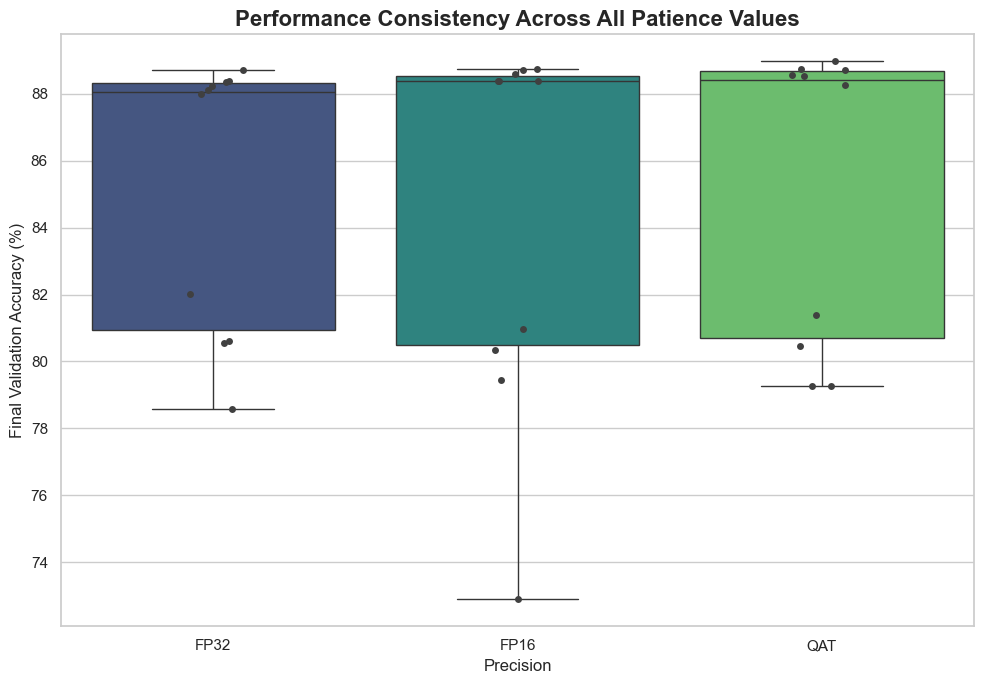

C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\2741944978.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_energy_df, x='precision', y='energy_kWh', palette='magma')


Saved energy per epoch plot to plot_10_energy_per_epoch.png


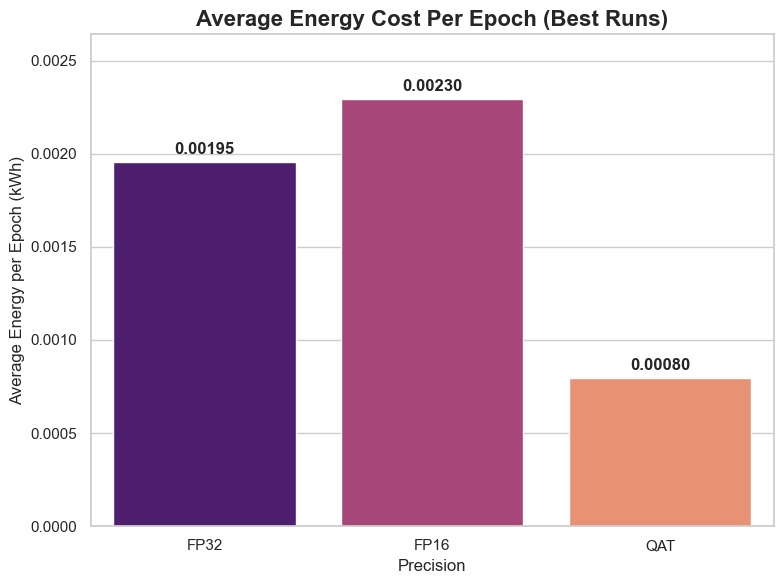

C:\Users\Priangshu Paul\AppData\Local\Temp\ipykernel_26456\2741944978.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=volatility_df, x='precision', y='loss_std_dev', palette='coolwarm')


Saved loss volatility plot to plot_11_loss_volatility.png


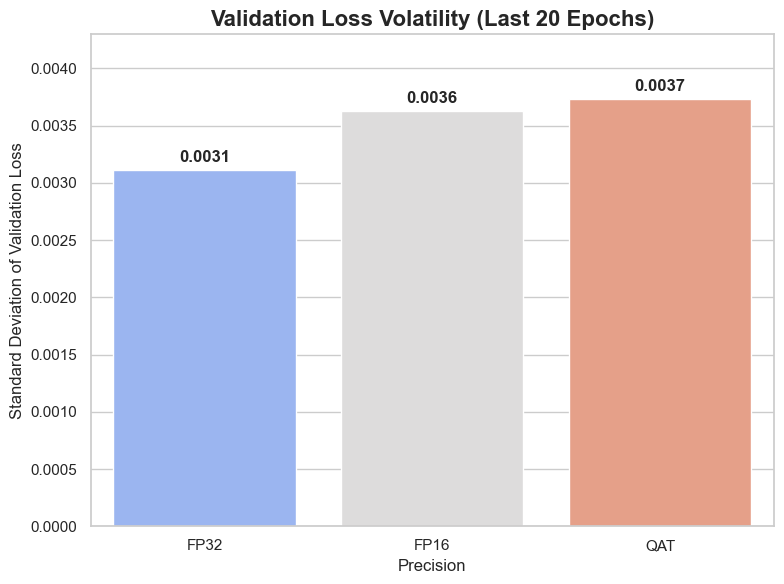

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np

# --- Configuration ---
RESULTS_DIR = 'results'
sns.set_theme(style="whitegrid")

# --- Data Loading and Processing (from previous code) ---

def load_data(results_dir):
    """Load all experiment logs into a single DataFrame."""
    all_files = glob.glob(os.path.join(results_dir, "results_*.csv"))
    if not all_files:
        print(f"Error: No CSV files found in the '{results_dir}' directory.")
        return pd.DataFrame()
        
    df_list = []
    for filename in all_files:
        try:
            parts = os.path.basename(filename).replace('.csv', '').split('_')
            precision = parts[1].upper()
            patience = int(parts[2][1:])
            df = pd.read_csv(filename)
            # Recalculate cumulative stats per file
            df['cumulative_energy_kWh'] = df['energy_kWh'].cumsum()
            df['precision'] = precision
            df['patience'] = patience
            df['filename'] = os.path.basename(filename)
            df_list.append(df)
        except Exception as e:
            print(f"Could not process file {filename}: {e}")
    return pd.concat(df_list, ignore_index=True)

def get_optimal_run_files(df):
    """Identify the filename of the best run for each precision type."""
    idx_max_acc_per_run = df.groupby(['precision', 'patience'])['val_acc'].idxmax()
    best_of_each_run_df = df.loc[idx_max_acc_per_run]
    idx_optimal_runs = best_of_each_run_df.groupby('precision')['val_acc'].idxmax()
    optimal_files = best_of_each_run_df.loc[idx_optimal_runs]['filename'].tolist()
    return optimal_files

# --- New Plotting Functions ---

def plot_performance_distribution(df, save_path="plot_9_performance_distribution.png"):
    """Plots the distribution of final accuracies across all patience values."""
    plt.figure(figsize=(10, 7))
    
    # Find the maximum accuracy for each precision-patience combination
    final_accuracies_df = df.groupby(['precision', 'patience'])['val_acc'].max().reset_index()

    sns.boxplot(data=final_accuracies_df, x='precision', y='val_acc', palette='viridis', order=['FP32', 'FP16', 'QAT'])
    sns.stripplot(data=final_accuracies_df, x='precision', y='val_acc', color=".25", order=['FP32', 'FP16', 'QAT'])

    plt.title('Performance Consistency Across All Patience Values', fontsize=16, weight='bold')
    plt.xlabel('Precision', fontsize=12)
    plt.ylabel('Final Validation Accuracy (%)', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved performance distribution plot to {save_path}")
    plt.show()


def plot_energy_per_epoch(df, optimal_files, save_path="plot_10_energy_per_epoch.png"):
    """Plots a bar chart of the average energy consumed per epoch."""
    plt.figure(figsize=(8, 6))
    
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    # Calculate the mean of the interval energy for each optimal run
    avg_energy_df = df_optimal.groupby('precision')['energy_kWh'].mean().reset_index()
    avg_energy_df = avg_energy_df.sort_values(by='precision', key=lambda x: x.map({'FP32':0, 'FP16':1, 'QAT':2}))


    ax = sns.barplot(data=avg_energy_df, x='precision', y='energy_kWh', palette='magma')

    plt.title('Average Energy Cost Per Epoch (Best Runs)', fontsize=16, weight='bold')
    plt.xlabel('Precision', fontsize=12)
    plt.ylabel('Average Energy per Epoch (kWh)', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.5f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')
    
    plt.ylim(0, avg_energy_df['energy_kWh'].max() * 1.15)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved energy per epoch plot to {save_path}")
    plt.show()


def plot_loss_volatility(df, optimal_files, last_n_epochs=20, save_path="plot_11_loss_volatility.png"):
    """Calculates and plots the standard deviation of validation loss for the final N epochs."""
    plt.figure(figsize=(8, 6))
    
    df_optimal = df[df['filename'].isin(optimal_files)]
    
    volatility = {}
    for precision in sorted(df_optimal['precision'].unique()):
        precision_df = df_optimal[df_optimal['precision'] == precision]
        # Get the last N epochs of data for that run
        last_epochs_df = precision_df.tail(last_n_epochs)
        # Calculate the standard deviation of the validation loss
        volatility[precision] = last_epochs_df['val_loss'].std()

    volatility_df = pd.DataFrame(list(volatility.items()), columns=['precision', 'loss_std_dev'])
    volatility_df = volatility_df.sort_values(by='precision', key=lambda x: x.map({'FP32':0, 'FP16':1, 'QAT':2}))

    ax = sns.barplot(data=volatility_df, x='precision', y='loss_std_dev', palette='coolwarm')

    plt.title(f'Validation Loss Volatility (Last {last_n_epochs} Epochs)', fontsize=16, weight='bold')
    plt.xlabel('Precision', fontsize=12)
    plt.ylabel('Standard Deviation of Validation Loss', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

    plt.ylim(0, volatility_df['loss_std_dev'].max() * 1.15)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"Saved loss volatility plot to {save_path}")
    plt.show()


# --- Main Execution Block ---
if __name__ == "__main__":
    # Load all the data from the results directory
    full_df = load_data(RESULTS_DIR)
    
    if not full_df.empty:
        # Find the best performing run for each precision
        optimal_files = get_optimal_run_files(full_df)
        print(f"Identified optimal run files for time-series plots: {optimal_files}\n")

        # Generate and display each plot
        plot_performance_distribution(full_df)
        plot_energy_per_epoch(full_df, optimal_files)
        plot_loss_volatility(full_df, optimal_files, last_n_epochs=20)
    else:
        print("Analysis aborted as no data was loaded.")